# How to use Tensorboard

- 基本的に，[このチュートリアル](https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html)の内容に基づいている．  
- Tensorflowの[Tensorboardチュートリアル](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks)も少し役に立つ．  

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# transforms for data conversion
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# load dataset (FashionMNIST)
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True, train=True , transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True, train=False, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## instantiate network
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [3]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
logs_base_dir = './runs/fashion_mnist_experiment_1'
writer = SummaryWriter(logs_base_dir)

ここで，**コマンドプロンプトを開き**，指定された場所でtensorboardを起動することをお勧めする．~~  

> ```sh
> > tensorboard --logdir=./runs/fashion_mnist_experiment_1 --port=6006
> ```

~~これの代替方法として，magic commandを使う方法もあるが，Windowsでは期待通りの動作が出来ないため，[tensorboardリポジトリのissues#3469](https://github.com/tensorflow/tensorboard/issues/3469)に臨時的な措置に従う．~~  

[Batchファイル](./run_TensorBoard.bat)を作ったので，そちらを実行すれば済むことだと思う．

In [4]:
'''
import subprocess, time

## another way to do
ls_output = subprocess.Popen(["tensorboard", "--logdir", logs_base_dir, 
                              "--port", "6006"])
time.sleep(1) ## waiting 1-sec
'''
pass

- 上のラインを実行し，[localhost:6006](http://localhost:6006)を開けばTensorboardがみられる．  
- Projectorに関しては処理が重いため，Chrome等のブラウザーではキャッシュの方が優先され，通常の更新(F5)ではProjectorが延々と出てこない場合がある．その時には，Ctrl+F5で強制更新を行えば良い．  

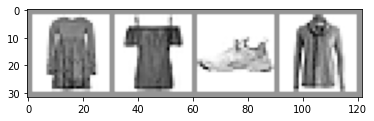

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [6]:
## network visualization
writer.add_graph(net, images)

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings [CAUTION] it doesn't work well...
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))

In [8]:
## abort writer for Tensorboard visualization
writer.close()

In [9]:
## 
'''
ls_output.terminate()
ls_output.kill()
'''
pass

## Miscellaneous: magic command

本来，以下のマジックコマンドでTensorboardが起動できるはずだが，何かバグなのか，期待通りの動作をしてくれない．  

> ```Python
> %load_ext tensorboard
> %tensorboard --logdir {logs_base_dir} --port 6006
> ```

(end)